In [2]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

In [3]:
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate

DH = DataHolder(**paths)

In [4]:
train_test = DH.stratified_train_test_split(feature = 'openface', speaker=1, none_count=50)
dataset = dicDataset(**train_test['data'])
class_weights = train_test['class_weights']
dataloader = DataLoader(dataset, batch_size = 50, shuffle = True, collate_fn = pad_collate)

In [18]:
#model = GRUModel(input_dim=17) #17 for openface, 23 for opensmile
#hist_train_loss = []
#hist_test_loss = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.MSELoss()

def eval_on_test():
    model.eval()
    tot_loss=0.0
    y_test = dataset.get_test()
    with torch.no_grad():
        pred = model(y_test['features'])
    loss = criterion(y_test['targets'], pred)
    tot_loss += loss / pred.shape[0]
    return loss


for epoch in range(100):
    model.train()

    epoch_loss = 0.0

    for batch in dataloader:

        pred = model(batch['features'])
        loss = criterion(batch['targets'], pred)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    hist_train_loss.append(loss)
    
    hist_test_loss.append(eval_on_test())

hist_train_loss = [x.detach().numpy() if type(x)==torch.Tensor else x for x in hist_train_loss]
hist_test_loss = [x.detach().numpy() if type(x)==torch.Tensor else x for x in hist_test_loss]

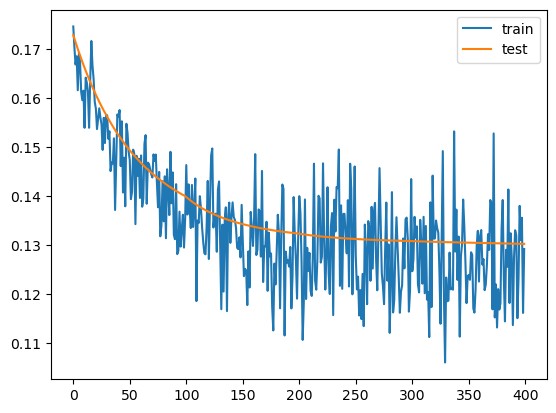

In [19]:
plt.plot(hist_train_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import classification_report
y_test = dataset.get_test()
pred_n = model(y_test['features']).detach().numpy()
y_true = y_test['targets'].detach().numpy()
print(classification_report(y_true,np.where(pred_n>.07,1,0)))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55        55
           1       0.08      0.75      0.15        12
           2       0.07      0.67      0.13        12
           3       0.29      0.33      0.31         6
           4       0.35      1.00      0.52        51

   micro avg       0.24      0.92      0.38       136
   macro avg       0.24      0.75      0.33       136
weighted avg       0.31      0.92      0.46       136
 samples avg       0.26      0.82      0.39       136



/Users/tancredeasselot/miniconda/envs/projet_ewen/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
pred_n

array([[0.4243674 , 0.14152929, 0.13470645, 0.09660263, 0.29900488],
       [0.38345692, 0.07283564, 0.07303257, 0.04968719, 0.34818226],
       [0.4236652 , 0.14034456, 0.13359194, 0.09551218, 0.29886454],
       [0.3958458 , 0.08111511, 0.08080902, 0.05486901, 0.32578653],
       [0.39553788, 0.08083398, 0.08058731, 0.05470968, 0.3263635 ],
       [0.3838778 , 0.07309074, 0.07327346, 0.04986083, 0.3475102 ],
       [0.38842937, 0.07601132, 0.07603189, 0.05169804, 0.33921736],
       [0.38500234, 0.07347554, 0.07379257, 0.05023465, 0.3461663 ],
       [0.4113135 , 0.09545986, 0.09409144, 0.06403949, 0.30025977],
       [0.38431647, 0.07325918, 0.07348958, 0.05000131, 0.3468503 ],
       [0.39523637, 0.08077855, 0.08045413, 0.05461884, 0.32666695],
       [0.39559102, 0.08101749, 0.08066805, 0.05478105, 0.3261663 ],
       [0.3798811 , 0.07058735, 0.07090978, 0.04828588, 0.3549197 ],
       [0.3810128 , 0.07131125, 0.07158709, 0.04872835, 0.35272065],
       [0.407225  , 0.09142432, 0.

In [ ]:
crit = torch.nn.MSELoss()

In [ ]:
#crit(y_test['targets'], torch.square(torch.randn(pred.shape)))
crit(y_test['targets'], y_test['targets'])

tensor(0.)

In [ ]:
crit(y_test['targets'], torch.zeros(pred.shape))

tensor(0.1889)

In [ ]:
y_test['targets']

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1